In [9]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
%matplotlib inline
from analysis.lib.purification import purify_analysis as pa; reload(pa)

<module 'analysis.lib.purification.purify_analysis' from 'd:/measuring\analysis\lib\purification\purify_analysis.pyc'>

In [10]:
import matplotlib as mpl


mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [11]:
# time stamp defs

#### compose the timestamps, used order is: X,mX,Y,mY,Z,mZ
### shown data is for pi/6 in the LDE element
daystamp = '20160817'
LT3_tstamp_list = ['140755','151440','142421','143655','144136','144736']
LT3_tstamp_list = [daystamp+'_'+s for s in LT3_tstamp_list]
LT3_ssro = r'K:\ns\qt\Diamond\Projects\Purification\Data\SSROs_lt3\combined_ssro_MWInit'
LT4_tstamp_list = ['172831','173338','175151','175644','150853','151312']
LT4_tstamp_list = [daystamp+'_'+s for s in LT4_tstamp_list]
LT4_ssro = r'K:\ns\qt\Diamond\Projects\Purification\Data\SSROs_lt4\combined_ssro'
base_folder_lt3 = r'K:\ns\qt\Diamond\Projects\Purification\Data\pur_lt3_local'
base_folder_lt4 = r'K:\ns\qt\Diamond\Projects\Purification\Data\pur_lt4_local'

In [12]:
#get data def
reload(mbi)
def do_carbon_ROC(f,f_u,setup):
    c = 2*(f-0.5)
    c_u = 2*f_u
    c,c_u = pa.do_carbon_ROC_1q(c,c_u,setup)
    return (c/2)+0.5,c_u/2

def get_MBI_data(tstamp,ssrofolder,setup):
    if setup == 'lt3':
        base_folder = base_folder_lt3
    elif setup == 'lt4':
        base_folder = base_folder_lt4
    else:
        raise ValueError('No setup specified in get_MBI_data')

    ### note that the data is not carbon read-out corrected.
    folder = tb.data_from_time(tstamp,folder = base_folder)
    #     ssro_folder = tb.data_from_time(ssrostamp)
    a = mbi.MBIAnalysis(folder)
    a.get_sweep_pts()
    a.get_readout_results(name='adwindata')
    a.get_electron_ROC(ssrofolder)
    a.p0,a.u_p0 = do_carbon_ROC(a.p0.reshape(-1)[:],a.u_p0.reshape(-1)[:],setup) #13C ROC
    return a.sweep_pts.reshape(-1)[:],a.p0,a.u_p0

def interpolate(x_in,y,y_u,x_ref):
    """
    Interpolates data such that new sweep points match a reference (x_ref)
    """
    new_y = np.zeros(len(x_ref))
    new_y_u = np.zeros(len(x_ref))

    new_y = np.interp(x_ref,x_in,y)
    new_y_u = np.interp(x_ref,x_in,y_u)
    
    print new_y,new_y_u
    return x_ref,new_y,new_y_u

In [13]:
### calc averages for bloch sphere
def return_avgs(Tstamps, ssro,setup):
    x_list,y_list,y_u_list = [],[],[]
    for t in Tstamps:
        x,y,y_u = get_MBI_data(t,ssro,setup)
        x_list.append(x);y_list.append(y);y_u_list.append(y_u)
        
       
    if len(x_list[0]) != len(x_list[1]): ### lt3 has a measurement with deviating number of points
        ## interpolate results:
        x_list[0],y_list[0],y_u_list[0] = interpolate(x_list[0],y_list[0],y_u_list[0],x_list[1])

    ### calculate average state fidelity
    avg_yXY = np.zeros(len(x_list[1]))
    avg_yXY_u = np.zeros(len(x_list[1]))
    avg_yZ = np.zeros(len(x_list[-1]))
    avg_yZ_u = np.zeros(len(x_list[-1]))

    ## get the avg XY values
    for y,y_u in zip(y_list[:-2],y_u_list[:-2]): ## assumption: all sweep points are the same
        avg_yXY = avg_yXY+(np.absolute(2*(y-0.5))/2+0.5)/4.
        avg_yXY_u = avg_yXY_u+y_u**2/16.

        ## get the avg Z values
    for y,y_u in zip(y_list[-2:],y_u_list[-2:]): 
        avg_yZ = avg_yZ+(np.absolute(2*(y-0.5))/2.+0.5)/2.
        avg_yZ_u = avg_yZ_u+y_u**2/4.    

    avg_yXY_u = np.sqrt(avg_yXY_u)
    avg_yZ_u = np.sqrt(avg_yZ_u)
    
    return x_list,y_list,y_u_list,avg_yXY,avg_yXY_u,avg_yZ,avg_yZ_u

In [14]:
x_list4,y_list4,y_u_list4,avg_yXY4,avg_yXY_u4,avg_yZ4,avg_yZ_u4 = return_avgs(LT4_tstamp_list,LT4_ssro,'lt4')
x_list3,y_list3,y_u_list3,avg_yXY3,avg_yXY_u3,avg_yZ3,avg_yZ_u3 = return_avgs(LT3_tstamp_list,LT3_ssro,'lt3')

[ 0.8592074   0.87387804  0.86525742  0.83925803  0.78359462  0.79915096
  0.78619559  0.74949915  0.75042965  0.7327598   0.72646794  0.63620024
  0.65835757  0.63457471  0.61752265  0.56123511  0.52782228] [ 0.0207608   0.0200556   0.02022902  0.02149471  0.02298692  0.02249407
  0.02295369  0.02387849  0.02373011  0.02427748  0.02423847  0.02561053
  0.0254238   0.02567226  0.02579508  0.02605842  0.02641091]


In [25]:
### fit XY decays:
# p0,fitfunc,fitfunc_str = common.fit_exp_decay_with_offset(0.5, 0.45, 300);fixed = [0]
p0,fitfunc,fitfunc_str = common.fit_general_exponential(0.5,0.45,0,250,1.4);fixed = [0,2]
fit_result4 = fit.fit1d(x_list4[0],avg_yXY4, None, p0=p0, fitfunc=fitfunc, do_print=True, ret=True,fixed=fixed)
fit_x4 = np.linspace(x_list4[0][0],x_list4[0][-1],600)
p0,fitfunc,fitfunc_str = common.fit_general_exponential(0.5,0.45,0,250,1.2);fixed = [0,2]
fit_result3 = fit.fit1d(x_list3[0],avg_yXY3, None, p0=p0, fitfunc=fitfunc, do_print=True, ret=True,fixed=fixed)
fit_x3 = np.linspace(x_list3[0][0],x_list3[0][-1],600)

Converged with chi squared  0.000936228397847
degrees of freedom, dof  14
RMS of residuals (i.e. sqrt(chisq/dof))  0.00817761927391
Reduced chisq (i.e. variance of residuals)  6.6873456989e-05

fitted parameters at minimum, with 68% C.I.:
 0 A              0.466054 +/-   0.005962
 1 T            272.185876 +/-   3.958910
 2 n              1.480507 +/-   0.053312

correlation matrix:
               A         T         n         
         A  1.000000
         T -0.705795  1.000000
         n -0.697361  0.420114  1.000000

Converged with chi squared  0.00148322646389
degrees of freedom, dof  14
RMS of residuals (i.e. sqrt(chisq/dof))  0.0102929464888
Reduced chisq (i.e. variance of residuals)  0.000105944747421

fitted parameters at minimum, with 68% C.I.:
 0 A              0.408653 +/-   0.006632
 1 T            272.907896 +/-   4.807151
 2 n              1.680834 +/-   0.097330

correlation matrix:
               A         T         n         
         A  1.000000
         T -0.498452  

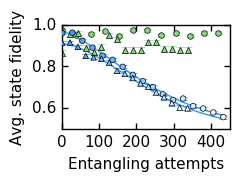

In [26]:
save_folder = r'K:\ns\qt\Diamond\Projects\Purification\Paper\Plots' 
### plot decays
golden_ratio = 1.61803
mm_to_inches = 0.0393701 ### inch/mm
figure_width = mm_to_inches*55
fig = plt.figure(figsize =(figure_width,figure_width/golden_ratio))
ax = plt.subplot(111)
### formatting
lw = 1.
fontsize = 11.
markersize = 4.

### colors
col_XY = '#3594F2'
# green = np.array([79/255.,166/255.,58/255.]) ### the color col_XY expressed in RGB values
blue = np.array([53,148,242])/255.
green = blue
white = np.array([1,1,1])
x_max4 = x_list4[0][-1]
x_max3 = x_list3[0][-1]
col_Z = '#82DB81' #130/219/129
orange_z = np.array([130,219,129])/255.# This is orange --> np.array([242,147,53])/255.
color_gradient4 = [(1-float(x)/x_max4)*green+(float(x)/x_max4)*white for x in x_list4[0]]
color_gradient24 = [(1-float(x)/x_max4)*orange_z+(float(x)/x_max4)*orange_z for x in x_list4[0]]
color_gradient3 = [(1-float(x)/x_max3)*green+(float(x)/x_max3)*white for x in x_list3[0]]
color_gradient23 = [(1-float(x)/x_max3)*orange_z+(float(x)/x_max3)*orange_z for x in x_list3[0]]


## apply formatting
ax.set_ylabel(r'Avg. state fidelity',size = fontsize)
ax.set_xlabel('Entangling attempts',size = fontsize)
ax.yaxis.set_ticks([0.4,0.6,0.8,1.0])
ax.xaxis.set_ticks([0,100,200,300,400])
ax.tick_params(labelsize = fontsize,width =lw)
ax.set_ylim([0.5,1])
ax.set_xlim([0,450])
[i.set_linewidth(lw) for i in ax.spines.itervalues()]


### plot data
ax.scatter(x_list4[0],avg_yXY4, c=color_gradient4, s=markersize**2, zorder=3,linewidths=lw/2.)
ax.errorbar(x_list4[0],avg_yXY4,avg_yXY_u4,fmt='.', markersize = 0,zorder=0,ecolor=col_XY,mew=lw/2.)
ax.errorbar(x_list4[-1],avg_yZ4,avg_yZ_u4,fmt = 'o',ms = markersize,color=col_Z,mew=lw/2.,zorder = 1)
ax.plot(fit_x4,fit_result4['fitfunc'](fit_x4),'-',color=col_XY,lw=lw,zorder = 0)

ax.scatter(x_list3[0],avg_yXY3, c=color_gradient3,marker = '^', s=markersize**2, zorder=3,linewidths=lw/2.)
ax.errorbar(x_list3[0],avg_yXY3,avg_yXY_u3,fmt='.', zorder=0, markersize = 0,ecolor=col_XY,mew=lw/2.)
ax.errorbar(x_list3[-1],avg_yZ3,avg_yZ_u3,fmt = '^',ms = markersize,color=col_Z,mew=lw/2.,zorder = 1)
ax.plot(fit_x4,fit_result3['fitfunc'](fit_x4),'-',color=col_XY,lw=lw,zorder = 0)
plt.savefig(os.path.join(save_folder,'memory_decay_comb.png'),format='png',bbox_inches = 'tight',pad_inches=0.3)
plt.savefig(os.path.join(save_folder,'memory_decay_comb.pdf'),format='pdf',bbox_inches = 'tight',pad_inches=0.3)

In [27]:
### bloch sphere LT3
from analysis.lib.purification import blochsphere_qutip as bl; reload(bl)
### convert all y entries to bloch vector coordinates
def plot_bloch(y_list,color_gradient,color_gradient2,name,marker = 'o'):
    bv_list = [2*(y-0.5) for y in y_list]


    b = bl.Bloch(figsize=[1.2,1.2])
    # b = bl.Bloch(figsize=[3.2,3.2])
    ## X values
    b.add_points([np.zeros(len(bv_list[4])),np.zeros(len(bv_list[4])),bv_list[4]],color2=True,invert_colors = False)
    b.add_points([np.zeros(len(bv_list[5])),np.zeros(len(bv_list[5])),bv_list[5]],color2=True,invert_colors = True)
    ## Y values
    b.add_points([-bv_list[2],np.zeros(len(bv_list[2])),np.zeros(len(bv_list[2]))])
    b.add_points([-bv_list[3][::-1],np.zeros(len(bv_list[3]))[::-1],np.zeros(len(bv_list[3]))[::-1]],invert_colors = True)
    ## Z values
    b.add_points([np.zeros(len(bv_list[0])),bv_list[0],np.zeros(len(bv_list[0]))],invert_colors = False)
    b.add_points([np.zeros(len(bv_list[1])),bv_list[1][::-1],np.zeros(len(bv_list[1]))],invert_colors = True)

    ## styling
    b.frame_alpha = 0.01
    b.point_marker = marker
    b.point_color  = color_gradient
    b.point_color2 = color_gradient2
    b.point_size   = [9]
    b.zlabel = ["$\\left| 0 \\right>$",""]#["X",""]
    b.ylabel = ["$\\left| X \\right>$",""]
    b.xlabel = ["","$\\left| Y \\right>$"]

    b.save(name =os.path.join(save_folder,'bloch_'+name+'.pdf'),format = 'pdf') 
#     b.save(name =os.path.join(save_folder,'bloch_'+name+'.png'),format = 'png')
#     b.show()


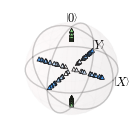

In [28]:
plot_bloch(y_list3,color_gradient3,color_gradient23,'LT3',marker = '^')

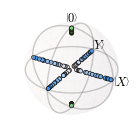

In [29]:
plot_bloch(y_list4,color_gradient4,color_gradient24,'LT4')

# Feedback vs. No feedback

reloaded
reloaded
2
starting fit.fit1d
Converged with chi squared  0.0365357459846
degrees of freedom, dof  27
RMS of residuals (i.e. sqrt(chisq/dof))  0.0367855376093
Reduced chisq (i.e. variance of residuals)  0.00135317577721

fitted parameters at minimum, with 68% C.I.:
 0 A              0.367467 +/-   0.011085
 1 T            243.339480 +/-  16.036371

correlation matrix:
               A         T         
         A  1.000000
         T -0.669914  1.000000

K:\ns\qt\Diamond\Projects\Purification\Data\pur_lt3_local\20160817\135340_purifcation slave_Pippin_SIL2_ADwin_phase_compensation_Z


d:/measuring\analysis\lib\tools\plot.py:40: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if fit_xvals == None:


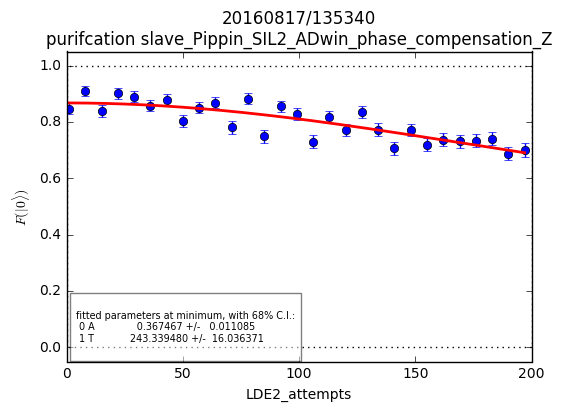

2
starting fit.fit1d
Converged with chi squared  0.0536715699636
degrees of freedom, dof  25
RMS of residuals (i.e. sqrt(chisq/dof))  0.0463342508145
Reduced chisq (i.e. variance of residuals)  0.00214686279854

fitted parameters at minimum, with 68% C.I.:
 0 A             -0.429987 +/-   0.019983
 1 T            273.193828 +/-  34.109657
 2 f              0.057252 +/-   0.000092
 3 phi          -49.526866 +/-   3.318884

correlation matrix:
               A         T         f         phi       
         A  1.000000
         T  0.691837  1.000000
         f -0.060530 -0.015573  1.000000
       phi  0.083879  0.042913 -0.826569  1.000000

K:\ns\qt\Diamond\Projects\Purification\Data\pur_lt3_local\20160817\132707_purifcation slave_Pippin_SIL2_ADwin_phase_compensation_Z


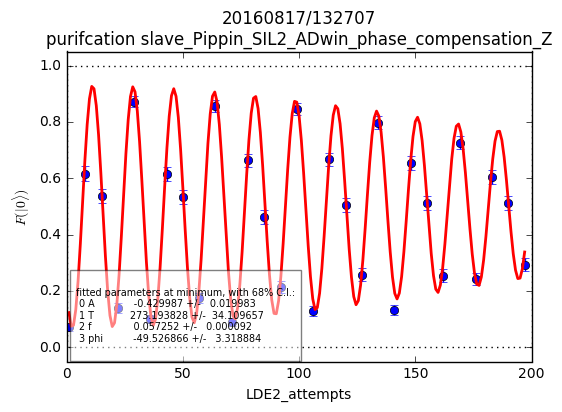

In [20]:
#### LT3

from analysis.scripts.mbi import mbi_data_general_fits as fits; reload(fits)
####
#parameters / timestamps
tstamp_feedback = '20160817_135340'
tstamp_no_feedback = '20160817_132707'
####
Result_w_feedback = fits.exp_sin(timestamp=  tstamp_feedback,
                      offset=[0.5], amplitude = [0.5], center = [0], decay_constant = [300], 
                      exp_power = [2],
                      frequency = [0.], phase =[0], 
                      fixed = [0,2,4,5,6], base_folder = base_folder_lt3,
                      ylim = None,ssro_folder = LT3_ssro,
                      plot_fit = True, do_print = True, show_guess = False)[0]
Result_wo_feedback = fits.exp_sin(timestamp=  tstamp_no_feedback,
                      offset=[0.5], amplitude = [0.5], center = [0], decay_constant = [300], 
                      exp_power = [2],base_folder = base_folder_lt3,
                      frequency = [0.04], phase =[0], 
                      fixed = [0,2,4],
                      ylim = None,ssro_folder = LT3_ssro,
                      plot_fit = True, do_print = True, show_guess = False)[0]

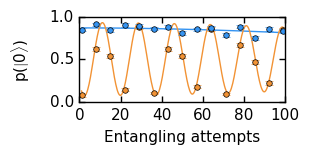

In [21]:
save_folder = r'K:\ns\qt\Diamond\Projects\Purification\Paper\Plots' 
golden_ratio = 1.61803
mm_to_inches = 0.0393701 ### inch/mm
figure_width = mm_to_inches*45
fig = plt.figure(figsize =(figure_width*1.5,figure_width/golden_ratio))
ax = plt.subplot(111)
x_wo_feed = np.linspace(Result_wo_feedback['x'][0],200,600)
x_w_feed = np.linspace(Result_w_feedback['x'][0],200,600)

### formatting
lw = 1
fontsize = 11
markersize = 4

col_w_feed = '#3594F2'
col_wo_feed = '#F29335'

ax.set_ylabel(r'p($|$0$\rangle$)',size = fontsize)
ax.set_xlabel('Entangling attempts',size = fontsize)
# ax.set_xticklabels([0,20,40,60,80,100],size = fontsize)
ax.yaxis.set_ticks([0.0,0.5,1.0])
# ax.set_yticklabels([0.0,0.5,1.0])
ax.xaxis.set_tick_params(width=lw,labelsize = fontsize)
ax.yaxis.set_tick_params(width=lw,labelsize = fontsize)
ax.set_xlim(0,100)
ax.set_ylim([0,1])
[i.set_linewidth(lw) for i in ax.spines.itervalues()]
ax.yaxis.set_label_coords(-0.23,0.5)
### commencde plotting
plt.plot(x_w_feed,Result_w_feedback['fitfunc'](x_w_feed),color = col_w_feed,lw=lw)
plt.plot(x_wo_feed,Result_wo_feedback['fitfunc'](x_wo_feed), color = col_wo_feed,lw = lw)
plt.errorbar(Result_wo_feedback['x'],Result_wo_feedback['y'],Result_wo_feedback['y_u'],fmt = 'o',color = col_wo_feed,ms = markersize,mew=lw/2.,elinewidth=lw)
plt.errorbar(Result_w_feedback['x'],Result_w_feedback['y'],Result_w_feedback['y_u'],fmt = 'o',color = col_w_feed,ms = markersize,mew=lw/2.,elinewidth=lw)
plt.savefig(os.path.join(save_folder,'feedback_nofeedback_LT3.png'),format='png',bbox_inches = 'tight',pad_inches=0.3)
plt.savefig(os.path.join(save_folder,'feedback_nofeedback_LT3.pdf'),format='pdf',bbox_inches = 'tight',pad_inches=0.3)

reloaded
2
starting fit.fit1d
Converged with chi squared  0.00719270739279
degrees of freedom, dof  13
RMS of residuals (i.e. sqrt(chisq/dof))  0.023522014881
Reduced chisq (i.e. variance of residuals)  0.000553285184061

fitted parameters at minimum, with 68% C.I.:
 0 A              0.465285 +/-   0.012041
 1 T           -232.788964 +/-  42.228395
 2 f              0.043218 +/-   0.000103
 3 phi           -1.845959 +/-   2.081292

correlation matrix:
               A         T         f         phi       
         A  1.000000
         T  0.708965  1.000000
         f -0.066310 -0.097276  1.000000
       phi  0.057616  0.069938 -0.860612  1.000000

K:\ns\qt\Diamond\Projects\Purification\Data\pur_lt4_local\20160817\132726_purifcation slave_111no2_SIL2_ADwin_phase_compensation_Z


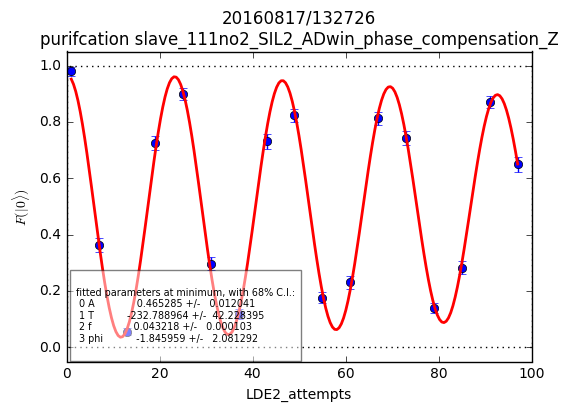

2
starting fit.fit1d
Converged with chi squared  0.00684418825509
degrees of freedom, dof  15
RMS of residuals (i.e. sqrt(chisq/dof))  0.0213606932707
Reduced chisq (i.e. variance of residuals)  0.000456279217006

fitted parameters at minimum, with 68% C.I.:
 0 A              0.442953 +/-   0.007846
 1 T            251.121718 +/-  33.758643

correlation matrix:
               A         T         
         A  1.000000
         T -0.720140  1.000000

K:\ns\qt\Diamond\Projects\Purification\Data\pur_lt4_local\20160817\141641_purifcation slave_111no2_SIL2_ADwin_phase_compensation_Z


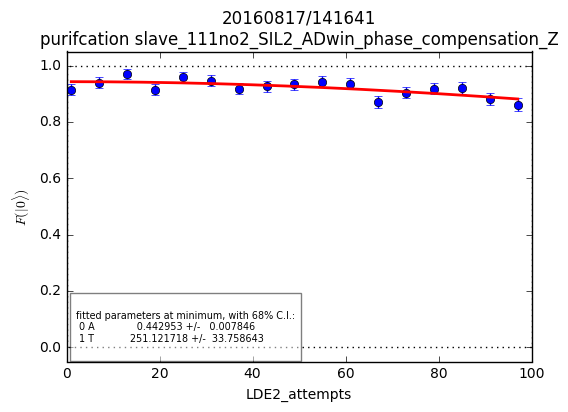

In [22]:
#### LT4
from analysis.scripts.mbi import mbi_data_general_fits as fits; reload(fits)
####
#parameters / timestamps
tstamp_feedback = '20160817_141641'
tstamp_no_feedback = '20160817_132726'
####
Result_wo_feedback = fits.exp_sin(timestamp=  tstamp_no_feedback,
                      offset=[0.5], amplitude = [0.5], center = [0], decay_constant = [300], 
                      exp_power = [2],ssro_folder = LT4_ssro,
                      frequency = [0.04],phase =[0], 
                      fixed = [0,2,4],
                      ylim = None,base_folder = base_folder_lt4,
                      plot_fit = True, do_print = True, show_guess = False)[0]
Result_w_feedback = fits.exp_sin(timestamp=  tstamp_feedback,
                      offset=[0.5], amplitude = [0.5], center = [0], decay_constant = [300], 
                      exp_power = [2],ssro_folder = LT4_ssro, base_folder = base_folder_lt4,
                      frequency = [0.], phase =[0], 
                      fixed = [0,2,4,5,6],
                      ylim = None,
                      plot_fit = True, do_print = True, show_guess = False)[0]


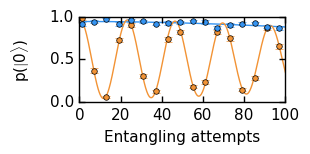

In [24]:
save_folder = r'K:\ns\qt\Diamond\Projects\Purification\Paper\Plots' 
golden_ratio = 1.61803
mm_to_inches = 0.0393701 ### inch/mm
figure_width = mm_to_inches*45
fig = plt.figure(figsize =(figure_width*1.5,figure_width/golden_ratio))
ax = plt.subplot(111)
x_wo_feed = np.linspace(Result_wo_feedback['x'][0],100,600)
x_w_feed = np.linspace(Result_w_feedback['x'][0],100,600)

### formatting
lw = 1
fontsize = 11
markersize = 4

col_w_feed = '#3594F2'
col_wo_feed = '#F29335'

ax.set_ylabel(r'p($|$0$\rangle$)',size = fontsize)
ax.set_xlabel('Entangling attempts',size = fontsize)
ax.set_xticklabels([0,20,40,60,80,100],size = fontsize)
ax.yaxis.set_ticks([0.0,0.5,1.0])
ax.set_yticklabels([0.0,0.5,1.0],size = fontsize)
ax.xaxis.set_tick_params(width=lw)
ax.yaxis.set_tick_params(width=lw)
ax.set_ylim([0,1])
[i.set_linewidth(lw) for i in ax.spines.itervalues()]
ax.yaxis.set_label_coords(-0.23,0.5)
### commencde plotting
plt.plot(x_w_feed,Result_w_feedback['fitfunc'](x_w_feed),color = col_w_feed,lw=lw)
plt.plot(x_wo_feed,Result_wo_feedback['fitfunc'](x_wo_feed), color = col_wo_feed,lw = lw)
plt.errorbar(Result_wo_feedback['x'],Result_wo_feedback['y'],Result_wo_feedback['y_u'],fmt = 'o',color = col_wo_feed,ms = markersize,mew=lw/2.,elinewidth=lw)
plt.errorbar(Result_w_feedback['x'],Result_w_feedback['y'],Result_w_feedback['y_u'],fmt = 'o',color = col_w_feed,ms = markersize,mew=lw/2.,elinewidth=lw)
plt.savefig(os.path.join(save_folder,'feedback_nofeedback_LT4.png'),format='png',bbox_inches = 'tight',pad_inches=0.3)
plt.savefig(os.path.join(save_folder,'feedback_nofeedback_LT4.pdf'),format='pdf',bbox_inches = 'tight',pad_inches=0.3)